# An Earth-Venus-Earth Link Budget from Open Research Institute
This document contains a detailed link budget analysis for Earth-Venus-Earth (EVE) communications. It contains context, experiemental worksheets for content that is planned to be moved into the EVELinkBudget class, and documentation.

The communications mode most similar to EVE is Earth-Moon-Earth (EME). EVE is more complex than EME communications due to several factors:

1. Much greater distances involved
2. Greater variability in the distances involved
3. Greater Doppler due to differences in how the orbital positions of Earth and Venus change with respect to each other when compared to the Earth and Moon
4. Different signal reflection characteristics from Venus compared to the Moon

The first part of our analysis sets the values that are true for us regardless of the celestial target. 1296 MHz (23cm band) is a common frequency for EME communications, and is the starting point for EVE. However, there's quite a bit of evidence showing that a frequency closer to 2450 MHz would be a better choice. The frequency can be changed in the LinkParameters data class, which is at the top of our lab notebook. 

Pointing error and tracking error need more attention and have their own cells below. For now, we use the numbers we have been given from Deep Space Exploration Society (DSES) who asked for assistance with this project. 


In [78]:
# Cell 1: Imports and class definitions
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional

@dataclass
class LinkParameters: #things that are true for us regardless of the target
    frequency_mhz: float = 1296.0 # Signal frequency
    tx_power_w: float = 1500.0 # Transmit power in watts
    tx_antenna_diameter_m: float = 18.29 # Transmit antenna diameter
    tx_antenna_efficiency: float = 0.69 # Transmit antenna efficiency
    rx_antenna_diameter_m: float = 18.29 # Receive antenna diameter
    rx_antenna_efficiency: float = 0.69 # Receive antenna efficiency
    tx_line_loss_db: float = 0.5 
    rx_line_loss_db: float = 0.5
    pointing_error_deg: float = 0.01 # Needs to be moved from worksheet to here
    tracking_error_deg: float = 0.01 # Needs to be moved from worksheet to here
    lna_noise_figure_db: float = 0.4
    receiver_noise_bandwidth: float = 100e3 # 
    c: float = 299792458  # Speed of light in m/s
    k: float = 1.380649e-23  # Boltzmann constant in J/K
    t0: float = 290  # Reference temperature in K
    

## EVELinkBudget Class
The link budget class is EVELinkBudget. It targets Venus as a reflective surface. We inherit all of our LinkParameters as params and can call upon them in this class. We then set up all our Venus specific characteristics and then define the functions that we need in order to calculate our link budget. We add up all the gains and subtract the losses. This gives power at the receiver. We calculate the noise in our receive bandwidth, and subtract it from power at the receiver. This gives a carrier to noise ratio in dB. Our communications mode must be able to meet this CNR in order to close the link. 

In [79]:
# Define the EVE link budget here - # Venus specific
class EVELinkBudget: 
    def __init__(self, params: LinkParameters):
        self.params = params

        # Venus characteristics
        self.venus_radius_km = 6051.8  # Venus radius in km
        self.venus_radar_albedo = 0.152  # Venus radar albedo (Radio Echo Observations of Venus and Mercury at 23 cm Wavelength, 1965)
        self.venus_atm_loss_db = -0.5  # Additional loss for Venus atmosphere (why same as Earth? Is this not already in radar albedo?)

        
    def wavelength(self) -> float:
        """Calculate wavelength in meters from frequency"""
        return self.params.c / (self.params.frequency_mhz * 1e6)

    def venus_reflection_gain(self) -> float:
        """Calculate billboard gain from Venus surface
        Using radar equation with Venus radar cross section
        Should we use additional factor of 0.7 for effective size?"""
        # Venus radar cross section = π * radius²
        # see https://hamradio.engineering/eme-path-loss-free-space-loss-passive-reflector-loss/
        venus_radius_m = self.venus_radius_km * 1000
        radar_cross_section = np.pi * venus_radius_m**2
        return 10 * np.log10(radar_cross_section)

    def venus_reflection_loss(self) -> float:
        # use radar albedo to get this loss
        return 10 * np.log10(self.venus_radar_albedo)
    
    def tx_antenna_gain(self) -> float:
        """Calculate transmitter antenna gain"""
        efficiency = self.params.tx_antenna_efficiency
        diameter = self.params.tx_antenna_diameter_m
        wavelength = self.wavelength()
        return 10 * np.log10(efficiency * (np.pi * diameter / wavelength) ** 2)
    
    def rx_antenna_gain(self) -> float:
        """Calculate receiver antenna gain"""
        efficiency = self.params.rx_antenna_efficiency
        diameter = self.params.rx_antenna_diameter_m
        wavelength = self.wavelength()
        return 10 * np.log10(efficiency * (np.pi * diameter / wavelength) ** 2)

    def free_space_loss(self, distance_km: float, round_trip: bool = True) -> float:
        """Calculate free space loss, optionally for round trip
        
        Args:
            distance_km: Distance in kilometers
            round_trip: If True, calculate round trip loss (both directions)
        """
        wavelength = self.wavelength()
        distance_m = distance_km * 1000
        one_way_loss = 20 * np.log10(4 * np.pi * distance_m / wavelength)
        return one_way_loss * 2 if round_trip else one_way_loss
    
    def pointing_loss(self) -> float:
        """Calculate pointing loss"""
        pointing_error_rad = np.radians(self.params.pointing_error_deg)
        tracking_error_rad = np.radians(self.params.tracking_error_deg)
        total_error_rad = np.sqrt(pointing_error_rad**2 + tracking_error_rad**2)
        return -12 * (total_error_rad / self.antenna_beamwidth_rad())**2
    
    def antenna_beamwidth_rad(self) -> float:
        """Calculate antenna beamwidth in radians"""
        return 1.22 * self.wavelength() / self.params.tx_antenna_diameter_m
    
    def calculate_link_budget(self, distance_km: float) -> dict:
        """Calculate complete link budget for a given distance"""
        # Convert transmit power to dBW
        tx_power_dbw = 10 * np.log10(self.params.tx_power_w)
        
        # Calculate antenna gains (only once each for TX and RX)
        tx_gain = self.tx_antenna_gain()
        rx_gain = self.rx_antenna_gain()
        venus_gain = self.venus_reflection_gain()
        
        # Calculate losses
        fs_loss = self.free_space_loss(distance_km, round_trip=True)
        point_loss = self.pointing_loss()
        venus_loss = self.venus_reflection_loss()
        
        # Calculate received power (passive reflection scenario)
        rx_power = (
            tx_power_dbw 
            + tx_gain  # TX antenna gain
            + rx_gain  # RX antenna gain
            - fs_loss  # Two-way path loss
            - self.params.tx_line_loss_db  # reported TX line loss at site
            - self.params.rx_line_loss_db  # reported RX line loss at site
            - point_loss  # Pointing loss - needs attention
            - venus_loss  # Venus reflection loss
            + venus_gain  # Venus reflection gain
        )
        
        # Calculate system noise
        t_sys = self.params.t0 * (10**(self.params.lna_noise_figure_db/10) - 1)
        noise_dbw = 10 * np.log10(self.params.k * t_sys * self.params.receiver_noise_bandwidth)  
        
        # Calculate CNR
        cnr = rx_power - noise_dbw
        
        return {
            'tx_power_dbw': tx_power_dbw,
            'tx_gain_db': tx_gain,
            'rx_gain_db': rx_gain,
            'free_space_loss_db': fs_loss,
            'pointing_loss_db': point_loss,
            'venus_reflection_loss_db': venus_loss,
            'venus_reflection_gain_db': venus_gain,
            'rx_power_dbw': rx_power,
            'noise_dbw': noise_dbw,
            'cnr_db': cnr
        }

        

## Link Budget Calculator Setup
We fetch all the LinkParameters and then create a calculator instance by saying EVELinkBudget(params). 
We've specified the class of EVELinkBudget. We're now creating an object where we can call the various methods inside of that class, which includes our calculate_link_budget(). Since the distance to Venus varies quite a bit, this is a parameter we need to provide. 

In [80]:
# Cell 2: Create calculator instance
params = LinkParameters()
calculator = EVELinkBudget(params)

## Effect of Distance on Received Power and Carrier-to-Noise Ratio

This part of the sheet shows the variation in received power and in CNR due to the variation in distance from Earth to Venus. 

In [81]:
# Cell 3: Calculate for Earth-Venus distances
min_distance_km = 38_000_000  # Minimum Earth-Venus distance
max_distance_km = 261_000_000  # Maximum Earth-Venus distance

# Create distance array for plotting
distances = np.linspace(min_distance_km, max_distance_km, 1000)
cnrs = []
rx_powers = []

for dist in distances:
    results = calculator.calculate_link_budget(dist)
    cnrs.append(results['cnr_db'])
    rx_powers.append(results['rx_power_dbw'])

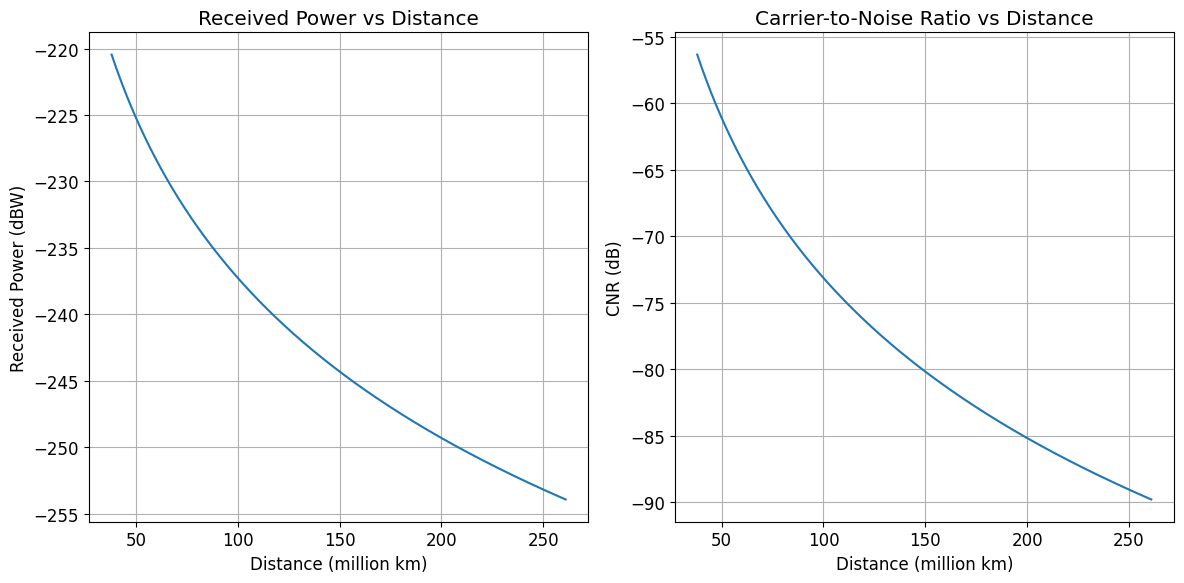

In [82]:
# Cell 4: Create plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(distances/1e6, rx_powers)
plt.grid(True)
plt.xlabel('Distance (million km)')
plt.ylabel('Received Power (dBW)')
plt.title('Received Power vs Distance')

plt.subplot(1, 2, 2)
plt.plot(distances/1e6, cnrs)
plt.grid(True)
plt.xlabel('Distance (million km)')
plt.ylabel('CNR (dB)')
plt.title('Carrier-to-Noise Ratio vs Distance')
plt.tight_layout()
plt.show()

## Pointing and Tracking Error Worksheets

Dish antennas have a narrow beamwidth. Pointing and tracking errors cost us in our link budget. This section models the pointing and tracking errors so that those amounts can be included in the link budget calculations. We return the pointing loss that corresponds to 1dB and 3dB signal loss. We plot pointing error vs. loss in a chart.  

In [83]:
# Cell 5: Parameters for dish analysis of pointing error 
class AntennaAnalysis:
    def __init__(self, params: LinkParameters):
        self.params = params
        
    def wavelength(self) -> float:
        """Calculate wavelength in meters from frequency in MHz"""
        frequency_hz = self.params.frequency_mhz * 1e6  # Convert MHz to Hz
        return self.params.c / frequency_hz
    
    def beamwidth_deg(self) -> float:
        """Calculate 3dB beamwidth in degrees"""
        # Using 1.22 λ/D formula for circular aperture
        return np.degrees(1.22 * self.wavelength() / self.params.tx_antenna_diameter_m)
    
    def pointing_loss_vs_error(self, max_error_deg: float = 0.5):
        """Calculate pointing loss for range of pointing errors"""
        errors = np.linspace(0, max_error_deg, 100)
        losses = -12 * (np.radians(errors) / np.radians(self.beamwidth_deg()))**2
        return errors, losses

# Create analyzer using params from link budget
analyzer = AntennaAnalysis(params)

# Calculate key parameters
beamwidth = analyzer.beamwidth_deg()
print(f"For a {analyzer.params.tx_antenna_diameter_m:.2f}m dish at {analyzer.params.frequency_mhz:.1f} MHz:")
print(f"3dB Beamwidth: {beamwidth:.3f} degrees")
print(f"Recommended max tracking error (1dB loss): {beamwidth/5.66:.3f} degrees") 
print(f"Recommended max tracking error (3dB loss): {beamwidth/2:.3f} degrees")

For a 18.29m dish at 1296.0 MHz:
3dB Beamwidth: 0.884 degrees
Recommended max tracking error (1dB loss): 0.156 degrees
Recommended max tracking error (3dB loss): 0.442 degrees


Let's explain these calculations because I didn't find it intuitive at first.

1. `beamwidth = analyzer.beamwidth_deg()`
   - This calculates the 3dB beamwidth (where power drops to half)
   - Uses the formula 1.22 * λ/D for a circular aperture
   - This is the "width" of your main beam

2. The tracking error recommendations come from the pointing loss formula we used earlier:
   ```python
   pointing_loss = -12 * (error_angle / beamwidth)**2
   ```
   This wasn't intuitive but it's in a lot of papers and seems legit. 

3. Working backwards from this formula:
   - For 1dB loss: -1 = -12 * (error/beamwidth)**2
   - Solving for error: error = beamwidth/√12 ≈ beamwidth/5.66
   
   - For 3dB loss: -3 = -12 * (error/beamwidth)**2
   - Solving for error: error = beamwidth/2

So if your beamwidth is (for example) 0.6 degrees:
- For 1dB loss: max error should be 0.6°/5.66 ≈ 0.106°
- For 3dB loss: max error should be 0.6°/2 = 0.3°

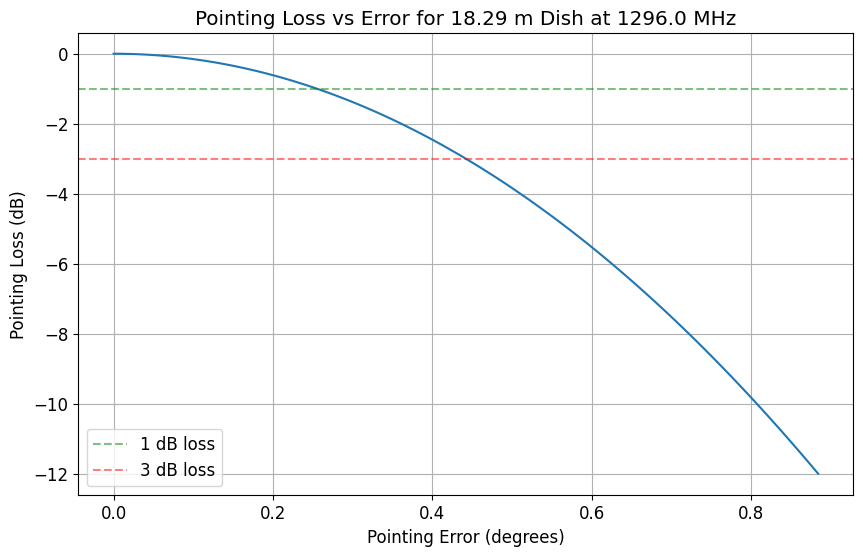

In [84]:
# Plot pointing loss vs error
errors, losses = analyzer.pointing_loss_vs_error(max_error_deg=beamwidth)

plt.figure(figsize=(10, 6))
plt.plot(errors, losses)
plt.grid(True)
plt.xlabel('Pointing Error (degrees)')
plt.ylabel('Pointing Loss (dB)')
plt.title(f'Pointing Loss vs Error for {params.tx_antenna_diameter_m:.2f} m Dish at {analyzer.params.frequency_mhz:.1f} MHz')

# Add horizontal lines for common loss thresholds
plt.axhline(y=-1, color='g', linestyle='--', alpha=0.5, label='1 dB loss')
plt.axhline(y=-3, color='r', linestyle='--', alpha=0.5, label='3 dB loss')
plt.legend()
plt.show()

## Pointing Error as a function of Tracking Error Normalized by Beamwidth

This is an experimental section to try and quantify the tracking error. Pointing error and tracking error are two different things, but notice that we get the same numerical results. Feedback here welcome and encouraged. 

Loss at error/beamwidth = 1/5.66: -0.37 dB
Loss at error/beamwidth = 1/2: -3.00 dB
Loss at error/beamwidth = 1/5.66: -0.37 dB
Loss at error/beamwidth = 1/2: -3.00 dB


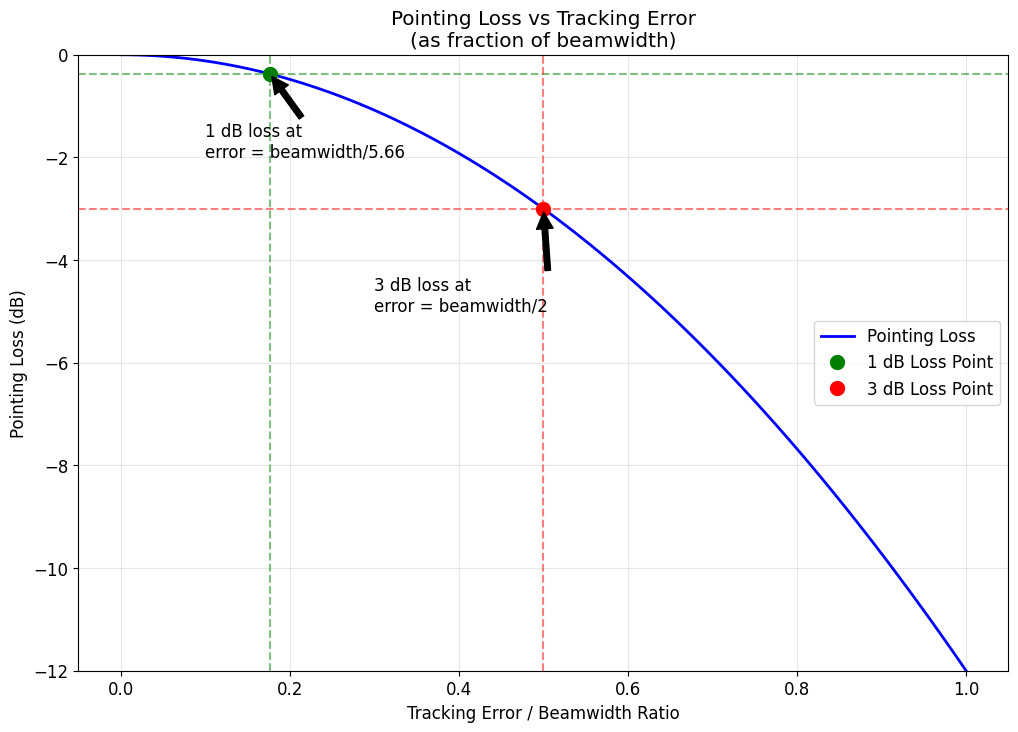


For your 18.29m dish at 0.0 MHz:
Beamwidth: 0.884°
Max tracking error for 1 dB loss: 0.156°
Max tracking error for 3 dB loss: 0.442°


In [85]:
# Cell 5: dish analysis of tracking error
#The visualization shows:
#The blue curve is the pointing loss vs tracking error (normalized to beamwidth)
#The green point shows where tracking error = beamwidth/5.66, giving 1 dB loss
#The red point shows where tracking error = beamwidth/2, giving 3 dB loss

#If your tracking error is less than beamwidth/5.66, your pointing loss is less than 1 dB
#At beamwidth/2, you've lost half your power (3 dB)
#The loss increases with the square of the error

def calculate_pointing_loss(error_angle, beamwidth):
    """Calculate pointing loss in dB given error angle and beamwidth"""
    return -12 * (error_angle / beamwidth)**2

# Create a range of error angles as fraction of beamwidth
error_fractions = np.linspace(0, 1, 100)

# Calculate losses
losses = calculate_pointing_loss(error_fractions, 1)

# Create the plot
plt.figure(figsize=(12, 8))

# Main loss curve
plt.plot(error_fractions, losses, 'b-', linewidth=2, label='Pointing Loss')

#Calculate losses at our specific points
loss_at_166 = calculate_pointing_loss(1/5.66, 1)
loss_at_half = calculate_pointing_loss(1/2, 1)

print(f"Loss at error/beamwidth = 1/5.66: {loss_at_166:.2f} dB")
print(f"Loss at error/beamwidth = 1/2: {loss_at_half:.2f} dB")

# Add markers for specific loss points
plt.plot(1/5.66, loss_at_166, 'go', markersize=10, label='1 dB Loss Point')
plt.plot(1/2, loss_at_half, 'ro', markersize=10, label='3 dB Loss Point')

# Add horizontal lines for loss levels
plt.axhline(y=loss_at_166, color='g', linestyle='--', alpha=0.5)
plt.axhline(y=loss_at_half, color='r', linestyle='--', alpha=0.5)

# Add vertical lines for error ratios
plt.axvline(x=1/5.66, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=1/2, color='r', linestyle='--', alpha=0.5)

# Customize the plot
plt.grid(True, alpha=0.3)
plt.xlabel('Tracking Error / Beamwidth Ratio')
plt.ylabel('Pointing Loss (dB)')
plt.title('Pointing Loss vs Tracking Error\n(as fraction of beamwidth)')

#Calculate losses at our specific points
loss_at_166 = calculate_pointing_loss(1/5.66, 1)
loss_at_half = calculate_pointing_loss(1/2, 1)

print(f"Loss at error/beamwidth = 1/5.66: {loss_at_166:.2f} dB")
print(f"Loss at error/beamwidth = 1/2: {loss_at_half:.2f} dB")

# Add text annotations
plt.annotate('1 dB loss at\nerror = beamwidth/5.66', 
            xy=(1/5.66, loss_at_166), xytext=(0.1, -2),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate('3 dB loss at\nerror = beamwidth/2', 
            xy=(1/2, loss_at_half), xytext=(0.3, -5),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()

# Set y-axis limits to focus on relevant range
plt.ylim(-12, 0)

plt.show()

# Print example calculations for your specific dish
beamwidth = analyzer.beamwidth_deg()
print(f"\nFor your {params.tx_antenna_diameter_m:.2f}m dish at {params.frequency_mhz/1e6:.1f} MHz:")
print(f"Beamwidth: {beamwidth:.3f}°")
print(f"Max tracking error for 1 dB loss: {beamwidth/5.66:.3f}°")
print(f"Max tracking error for 3 dB loss: {beamwidth/2:.3f}°")

## Link Budget at Minimum and Maximum Distance

Here is the CNR at a particular receiver bandwidth for minimum and maximum distance from Earth to Venus. 

In [86]:
# Cell 6: Print detailed results for minimum and maximum distances
min_results = calculator.calculate_link_budget(min_distance_km)
max_results = calculator.calculate_link_budget(max_distance_km)

print(f"Link Budget at Minimum Distance (38 million km) at {params.receiver_noise_bandwidth/1e6} MHz receiver bandwidth")
for key, value in min_results.items():
    print(f"{key}: {value:.2f}")

print(f"\nLink Budget at Maximum Distance (261 million km) at {params.receiver_noise_bandwidth/1e6} MHz receiver bandwidth")
for key, value in max_results.items():
    print(f"{key}: {value:.2f}")

Link Budget at Minimum Distance (38 million km) at 0.1 MHz receiver bandwidth
tx_power_dbw: 31.76
tx_gain_db: 46.29
rx_gain_db: 46.29
free_space_loss_db: 492.59
pointing_loss_db: -0.00
venus_reflection_loss_db: -8.18
venus_reflection_gain_db: 140.61
rx_power_dbw: -220.45
noise_dbw: -164.13
cnr_db: -56.32

Link Budget at Maximum Distance (261 million km) at 0.1 MHz receiver bandwidth
tx_power_dbw: 31.76
tx_gain_db: 46.29
rx_gain_db: 46.29
free_space_loss_db: 526.07
pointing_loss_db: -0.00
venus_reflection_loss_db: -8.18
venus_reflection_gain_db: 140.61
rx_power_dbw: -253.93
noise_dbw: -164.13
cnr_db: -89.80


## What Communication Modes Will Work?

This section is an attempt to show which communications modes close the link. We have CNR and a receive bandwidth. We want to create a visualization of the modes that will close the link. 

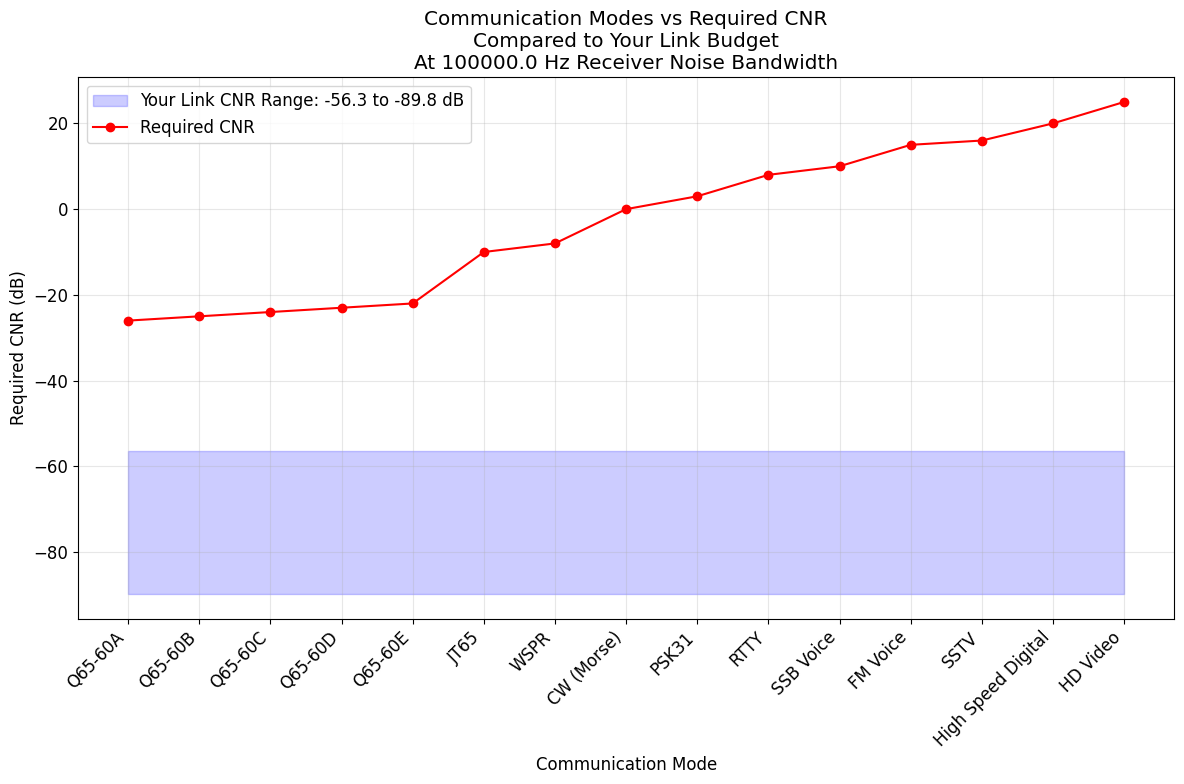


Communication Mode Analysis:
Your link CNR range: -56.3 dB to -89.8 dB

Possible communication modes:
Q65-60A         ✗ Not possible
Q65-60B         ✗ Not possible
Q65-60C         ✗ Not possible
Q65-60D         ✗ Not possible
Q65-60E         ✗ Not possible
JT65            ✗ Not possible
WSPR            ✗ Not possible
CW (Morse)      ✗ Not possible
PSK31           ✗ Not possible
RTTY            ✗ Not possible
SSB Voice       ✗ Not possible
FM Voice        ✗ Not possible
SSTV            ✗ Not possible
High Speed Digital ✗ Not possible
HD Video        ✗ Not possible


In [87]:
# Dictionary of common communication modes and their minimum required CNR
comm_modes = {
    'Q65-60A': -26,  # Best for minimal spread
    'Q65-60B': -25,  # For moderate spread
    'Q65-60C': -24,  # For higher spread
    'Q65-60D': -23,  # For very high spread
    'Q65-60E': -22,  # For extreme spread
    'JT65': -10,
    'WSPR': -8,
    'CW (Morse)': 0,
    'PSK31': 3,
    'RTTY': 8,
    'SSB Voice': 10,
    'FM Voice': 15,
    'SSTV': 16,
    'High Speed Digital': 20,
    'HD Video': 25
}

# Get your link budget CNR values from earlier calculations
min_results = calculator.calculate_link_budget(min_distance_km)
max_results = calculator.calculate_link_budget(max_distance_km)

min_cnr = min_results['cnr_db']
max_cnr = max_results['cnr_db']

# Create visualization
plt.figure(figsize=(12, 8))

# Plot CNR requirements as horizontal lines
modes = list(comm_modes.keys())
cnrs = list(comm_modes.values())

# Create range for your link's CNR
cnr_range = np.linspace(min_cnr, max_cnr, 100)
plt.fill_between([0, len(modes)-1], min_cnr, max_cnr, alpha=0.2, color='blue', 
                 label=f'Your Link CNR Range: {min_cnr:.1f} to {max_cnr:.1f} dB')

# Plot mode requirements
plt.plot(range(len(modes)), cnrs, 'ro-', label='Required CNR')

# Customize plot
plt.grid(True, alpha=0.3)
plt.xlabel('Communication Mode')
plt.ylabel('Required CNR (dB)')
plt.title(f'Communication Modes vs Required CNR\nCompared to Your Link Budget\nAt {params.receiver_noise_bandwidth} Hz Receiver Noise Bandwidth')

# Rotate x-axis labels for better readability
plt.xticks(range(len(modes)), modes, rotation=45, ha='right')

plt.legend()
plt.tight_layout()
plt.show()

# Print analysis
print("\nCommunication Mode Analysis:")
print(f"Your link CNR range: {min_cnr:.1f} dB to {max_cnr:.1f} dB")
print("\nPossible communication modes:")
for mode, required_cnr in comm_modes.items():
    if max_cnr >= required_cnr:
        margin_best = max_cnr - required_cnr
        margin_worst = min_cnr - required_cnr
        status = "✓ Always possible" if min_cnr >= required_cnr else "~ Sometimes possible"
        print(f"{mode:15} {status:20} (Margin: {margin_worst:.1f} to {margin_best:.1f} dB)")
    else:
        print(f"{mode:15} ✗ Not possible")

## How much Doppler do we Have?

We will have to anticipate and "track out" Doppler. How much Doppler do we have to deal with? This section quantifies how much we have, and also shows how much Doppler spread our potential communications modes can tolerate "on their own". We want to compare this to the "expected" Doppler of the link. Right now, it is set to 10% of maximum Doppler. We read that several hundred kHz of Doppler between Earth and Venus can occur.

To get our maximum result, we calculated a maximum relative velocity. This calculation needs review. 

The "expected" Doppler is simply 10% of the maximum, which also needs review. 

This section needs some attention from someone that knows how to show Earth-Venus Doppler so we can gain better expectations of the requirements of the link. 

Doppler Analysis for Venus Link:
Maximum possible Doppler shift: 283013.2 Hz
Typical expected Doppler spread: 28301.3 Hz

Suitable Q65 variants for your link:


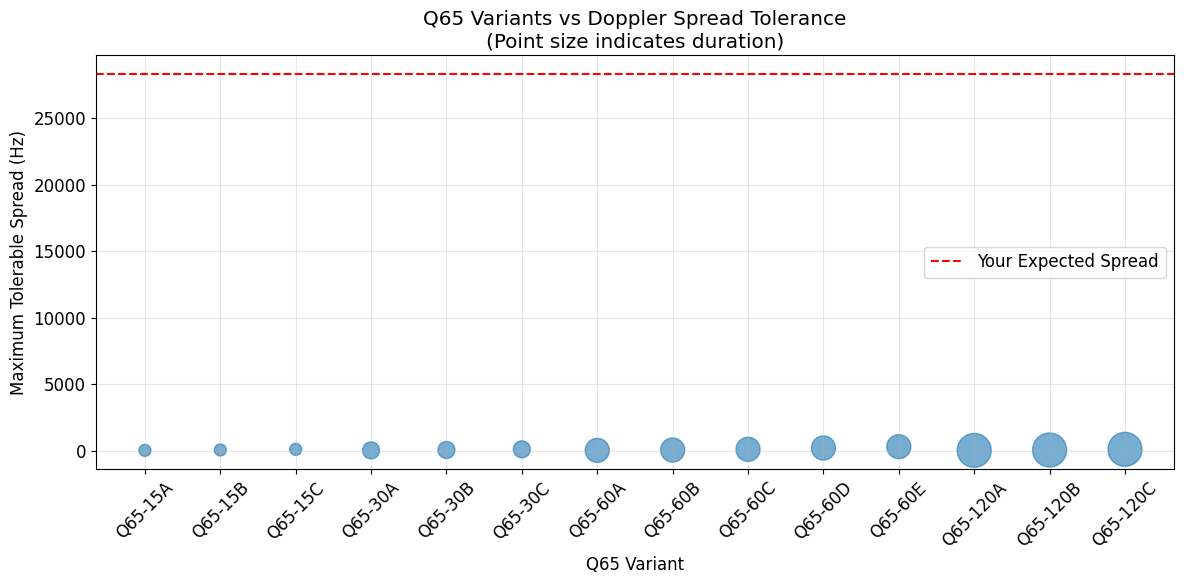

In [90]:
class AntennaAnalysis:
    def __init__(self, params: LinkParameters):
        self.params = params
        
class DopplerAnalysis:
    def __init__(self, params: LinkParameters):
        self.params = params
        
    def calculate_doppler_shift(self, velocity_ms: float) -> float:
        """Calculate Doppler shift for a given relative velocity,
        Convert our frequency in MHz to Hz."""
        return params.frequency_mhz * (velocity_ms / params.c) * 1e6
    
    def venus_doppler_spread(self) -> dict:
        """Calculate Doppler effects for Venus communication"""
        # Venus orbital velocity: ~35 km/s
        venus_orbital_v = 35000
        # Earth orbital velocity: ~30 km/s
        earth_orbital_v = 30000
        # Earth rotation: ~0.465 km/s at equator
        earth_rotation_v = 465
        # Venus rotation: ~0.002 km/s (very slow retrograde)
        venus_rotation_v = 2
        
        # Maximum relative velocity possible
        max_relative_v = venus_orbital_v + earth_orbital_v + earth_rotation_v + venus_rotation_v
        
        # Calculate maximum Doppler shift
        max_doppler = self.calculate_doppler_shift(max_relative_v)
        
        return {
            'max_doppler_hz': max_doppler,
            'typical_spread_hz': max_doppler * 0.1  # Typical spread during communication
        }

# Create dictionary of Q65 variants with their characteristics
q65_variants = {
    'Q65-15A': {'duration': 15, 'min_cnr': -25, 'max_spread': 20},
    'Q65-15B': {'duration': 15, 'min_cnr': -24, 'max_spread': 50},
    'Q65-15C': {'duration': 15, 'min_cnr': -23, 'max_spread': 100},
    'Q65-30A': {'duration': 30, 'min_cnr': -26, 'max_spread': 20},
    'Q65-30B': {'duration': 30, 'min_cnr': -25, 'max_spread': 50},
    'Q65-30C': {'duration': 30, 'min_cnr': -24, 'max_spread': 100},
    'Q65-60A': {'duration': 60, 'min_cnr': -27, 'max_spread': 20},
    'Q65-60B': {'duration': 60, 'min_cnr': -26, 'max_spread': 50},
    'Q65-60C': {'duration': 60, 'min_cnr': -25, 'max_spread': 100},
    'Q65-60D': {'duration': 60, 'min_cnr': -24, 'max_spread': 200},
    'Q65-60E': {'duration': 60, 'min_cnr': -23, 'max_spread': 300},
    'Q65-120A': {'duration': 120, 'min_cnr': -28, 'max_spread': 20},
    'Q65-120B': {'duration': 120, 'min_cnr': -27, 'max_spread': 50},
    'Q65-120C': {'duration': 120, 'min_cnr': -26, 'max_spread': 100}
}

# Analyze Doppler for your link
analyzer = DopplerAnalysis(params.frequency_mhz)
doppler_results = analyzer.venus_doppler_spread()

print("Doppler Analysis for Venus Link:")
print(f"Maximum possible Doppler shift: {doppler_results['max_doppler_hz']:.1f} Hz")
print(f"Typical expected Doppler spread: {doppler_results['typical_spread_hz']:.1f} Hz")

print("\nSuitable Q65 variants for your link:")
for variant, specs in q65_variants.items():
    if specs['max_spread'] >= doppler_results['typical_spread_hz']:
        margin = specs['max_spread'] - doppler_results['typical_spread_hz']
        print(f"{variant:8} - Duration: {specs['duration']}s, Spread Margin: {margin:.1f} Hz")

# Visualize the spread requirements
plt.figure(figsize=(12, 6))
variants = list(q65_variants.keys())
max_spreads = [specs['max_spread'] for specs in q65_variants.values()]
durations = [specs['duration'] for specs in q65_variants.values()]

# Create scatter plot with point size based on duration
plt.scatter(variants, max_spreads, s=[d*5 for d in durations], alpha=0.6)
plt.axhline(y=doppler_results['typical_spread_hz'], color='r', linestyle='--', 
           label='Your Expected Spread')

plt.grid(True, alpha=0.3)
plt.xlabel('Q65 Variant')
plt.ylabel('Maximum Tolerable Spread (Hz)')
plt.title('Q65 Variants vs Doppler Spread Tolerance\n(Point size indicates duration)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Reflection and Loss Analysis Worksheet

These calculations walk through the reflection loss and billboard gain of Venus and the Moon. Results have been provisionally moved (pending more review) to the EVELinkBudget Class. 

In [91]:
# Worksheet to play around with the reflection and loss analysis.
# Results here are moved into the mainline code.
class BillboardReflectionAnalysis:
    def __init__(self, frequency_mhz: float = 1296.0):
        self.frequency = frequency_mhz * 1e6
        self.c = 299792458
        self.wavelength = self.c / self.frequency
        
        # Target characteristics
        self.venus_radius_km = 6051.8
        self.moon_radius_km = 1737.4
        self.venus_albedo = 0.15
        self.moon_albedo = 0.07
        self.venus_atm_loss_db = -0.5  # Additional loss for Venus atmosphere
    
    def calculate_reflection_loss(self, albedo: float) -> float:
        """Calculate loss due to surface reflection"""
        return 10 * np.log10(albedo)
    
    def billboard_gain(self, radius_km: float, libration_angle_deg: float = 0) -> dict:
        """Calculate billboard gain for a disc reflector"""
        radius_m = radius_km * 1000
        
        # Adjust for libration
        libration_factor = np.cos(np.radians(libration_angle_deg))
        effective_area = np.pi * radius_m**2 * libration_factor
        
        # Billboard gain
        gain = 4 * np.pi * (effective_area / (self.wavelength**2))
        gain_db = 10 * np.log10(gain)
        
        return {
            'theoretical_gain_db': gain_db,
            'libration_factor_db': 10 * np.log10(libration_factor),
            'total_gain_db': gain_db + 10 * np.log10(libration_factor)
        }
    
    def complete_analysis(self, libration_angle_deg: float = 0):
        """Complete reflection analysis for both bodies as disc reflectors"""
        # Moon analysis
        moon_refl_loss = self.calculate_reflection_loss(self.moon_albedo)
        moon_billboard = self.billboard_gain(self.moon_radius_km, libration_angle_deg)
        moon_total = moon_billboard['total_gain_db'] + moon_refl_loss
        
        # Venus analysis (using same billboard approach)
        venus_refl_loss = self.calculate_reflection_loss(self.venus_albedo)
        venus_billboard = self.billboard_gain(self.venus_radius_km, libration_angle_deg)
        venus_total = venus_billboard['total_gain_db'] + venus_refl_loss + self.venus_atm_loss_db
        
        print(f"\nReflection Analysis at {self.frequency/1e6:.1f} MHz (Billboard Model):")
        
        print("\nMoon Analysis:")
        print(f"Billboard Gain: {moon_billboard['total_gain_db']:.1f} dB")
        print(f"Surface Reflection Loss: {moon_refl_loss:.1f} dB")
        print(f"Total Effect: {moon_total:.1f} dB")
        
        print("\nVenus Analysis:")
        print(f"Billboard Gain: {venus_billboard['total_gain_db']:.1f} dB")
        print(f"Surface Reflection Loss: {venus_refl_loss:.1f} dB")
        print(f"Atmospheric Loss: {self.venus_atm_loss_db:.1f} dB")
        print(f"Total Effect: {venus_total:.1f} dB")
        
        # Calculate effective cross-sectional areas
        moon_area = np.pi * (self.moon_radius_km * 1000)**2
        venus_area = np.pi * (self.venus_radius_km * 1000)**2
        print(f"\nRelative Size Comparison:")
        print(f"Venus/Moon area ratio: {venus_area/moon_area:.1f}")
        
        return {
            'moon': {'billboard': moon_billboard, 'reflection_loss': moon_refl_loss, 'total': moon_total},
            'venus': {'billboard': venus_billboard, 'reflection_loss': venus_refl_loss, 'total': venus_total}
        }

# Create analyzer and run analysis
analyzer = BillboardReflectionAnalysis(params.frequency_mhz)
results = analyzer.complete_analysis(libration_angle_deg=3)

# Calculate path losses for total effect
moon_distance_km = 384400
venus_min_distance_km = 38_000_000
venus_max_distance_km = 261_000_000

def path_loss(distance_km, frequency_hz):
    wavelength = 299792458 / frequency_hz
    distance_m = distance_km * 1000
    return 40 * np.log10(4 * np.pi * distance_m / wavelength)  # Two-way path loss

print("\nPath Loss Comparison:")
print(f"Moon ({moon_distance_km:,} km): {path_loss(moon_distance_km, analyzer.frequency):.1f} dB")
print(f"Venus min ({venus_min_distance_km:,} km): {path_loss(venus_min_distance_km, analyzer.frequency):.1f} dB")
print(f"Venus max ({venus_max_distance_km:,} km): {path_loss(venus_max_distance_km, analyzer.frequency):.1f} dB")

# Calculate total path effects
moon_total = results['moon']['total'] - path_loss(moon_distance_km, analyzer.frequency)
venus_min_total = results['venus']['total'] - path_loss(venus_min_distance_km, analyzer.frequency)
venus_max_total = results['venus']['total'] - path_loss(venus_max_distance_km, analyzer.frequency)

print("\nTotal Path Effects (Billboard Gain + Reflection Loss + Path Loss):")
print(f"Moon: {moon_total:.1f} dB")
print(f"Venus (minimum distance): {venus_min_total:.1f} dB")
print(f"Venus (maximum distance): {venus_max_total:.1f} dB")


Reflection Analysis at 1296.0 MHz (Billboard Model):

Moon Analysis:
Billboard Gain: 153.5 dB
Surface Reflection Loss: -11.5 dB
Total Effect: 141.9 dB

Venus Analysis:
Billboard Gain: 164.3 dB
Surface Reflection Loss: -8.2 dB
Atmospheric Loss: -0.5 dB
Total Effect: 155.6 dB

Relative Size Comparison:
Venus/Moon area ratio: 12.1

Path Loss Comparison:
Moon (384,400 km): 412.8 dB
Venus min (38,000,000 km): 492.6 dB
Venus max (261,000,000 km): 526.1 dB

Total Path Effects (Billboard Gain + Reflection Loss + Path Loss):
Moon: -270.9 dB
Venus (minimum distance): -337.0 dB
Venus (maximum distance): -370.5 dB


## Mode Analysis (Not Finished)

This in intended to be a detailed analysis of potential modes and their suitability for the link. Don't use this yet - it's not anywhere close to being finished. 

In [92]:
import numpy as np # suspected bad

class ModeCNRAnalysis:
    def __init__(self, params: LinkParameters):
        self.params = params
        
        # Define common modes and their bandwidths
        self.modes = {
            'CW': 2.0,          # 2 Hz bandwidth
            'Q65-60A': 60.0,    # 60 Hz bandwidth
            'Q65-60B': 60.0,
            'Q65-60C': 60.0,
            'Q65-120': 60.0,
            'JT65': 180.0,      # 180 Hz bandwidth
            'SSB': 2400.0,      # 2.4 kHz bandwidth
            'Wide': 1e6         # 1 MHz reference bandwidth
        }
        
        # Mode minimum required CNR
        self.mode_required_cnr = {
            'CW': 0,            # 0 dB minimum
            'Q65-60A': -26,     # -26 dB minimum
            'Q65-60B': -25,
            'Q65-60C': -24,
            'Q65-120': -28,
            'JT65': -10,
            'SSB': 12,
            'Wide': 0
        }
    
    def convert_cnr_for_bandwidth(self, cnr_1mhz: float, new_bandwidth_hz: float) -> float:
        """Convert CNR from 1MHz reference to new bandwidth"""
        bw_ratio = 1e6 / new_bandwidth_hz
        return cnr_1mhz + 10 * np.log10(bw_ratio)
    
    def analyze_modes(self, rx_power_dbw: float):
        """Analyze CNR and margin for all modes"""
        # First calculate CNR for 1 MHz reference
        t_sys = self.params.t0 * (10**(self.params.lna_noise_figure_db/10) - 1)
        noise_1mhz = 10 * np.log10(self.params.k * t_sys * 1e6)
        cnr_1mhz = rx_power_dbw - noise_1mhz
        
        results = {}
        for mode, bandwidth in self.modes.items():
            # Convert CNR to mode's bandwidth
            mode_cnr = self.convert_cnr_for_bandwidth(cnr_1mhz, bandwidth)
            margin = mode_cnr - self.mode_required_cnr[mode]
            
            results[mode] = {
                'bandwidth_hz': bandwidth,
                'bw_improvement_db': 10 * np.log10(1e6 / bandwidth),
                'cnr_db': mode_cnr,
                'required_cnr': self.mode_required_cnr[mode],
                'margin_db': margin,
                'viable': margin > 0
            }
        
        return {'reference_cnr_1mhz': cnr_1mhz, 'modes': results}

def print_mode_analysis(results):
    ref_cnr = results['reference_cnr_1mhz']
    print(f"\nReference CNR (1 MHz): {ref_cnr:.1f} dB")
    print("\nMode Analysis Results:")
    print(f"{'Mode':<10} {'BW (Hz)':<10} {'BW Gain':<10} {'CNR':<10} {'Req CNR':<10} {'Margin':<10} {'Viable'}")
    print("-" * 75)
    
    for mode, data in results['modes'].items():
        viable = "Yes" if data['viable'] else "No"
        print(f"{mode:<10} {data['bandwidth_hz']:<10.1f} {data['bw_improvement_db']:+.1f} dB "
              f"{data['cnr_db']:+.1f} dB {data['required_cnr']:+.1f} dB {data['margin_db']:+.1f} dB {viable}")

# Example usage:
# Calculate for both minimum and maximum Venus distances
min_distance_km = 38_000_000
max_distance_km = 261_000_000

params = LinkParameters()
calculator = EVELinkBudget(params)
mode_analyzer = ModeCNRAnalysis(params)

# Analyze for minimum distance
min_results = calculator.calculate_link_budget(min_distance_km)
mode_results_min = mode_analyzer.analyze_modes(min_results['rx_power_dbw'])

print("\nAt minimum Venus distance:")
print_mode_analysis(mode_results_min)

# Analyze for maximum distance
max_results = calculator.calculate_link_budget(max_distance_km)
mode_results_max = mode_analyzer.analyze_modes(max_results['rx_power_dbw'])

print("\nAt maximum Venus distance:")
print_mode_analysis(mode_results_max)


At minimum Venus distance:

Reference CNR (1 MHz): -66.3 dB

Mode Analysis Results:
Mode       BW (Hz)    BW Gain    CNR        Req CNR    Margin     Viable
---------------------------------------------------------------------------
CW         2.0        +57.0 dB -9.3 dB +0.0 dB -9.3 dB No
Q65-60A    60.0       +42.2 dB -24.1 dB -26.0 dB +1.9 dB Yes
Q65-60B    60.0       +42.2 dB -24.1 dB -25.0 dB +0.9 dB Yes
Q65-60C    60.0       +42.2 dB -24.1 dB -24.0 dB -0.1 dB No
Q65-120    60.0       +42.2 dB -24.1 dB -28.0 dB +3.9 dB Yes
JT65       180.0      +37.4 dB -28.9 dB -10.0 dB -18.9 dB No
SSB        2400.0     +26.2 dB -40.1 dB +12.0 dB -52.1 dB No
Wide       1000000.0  +0.0 dB -66.3 dB +0.0 dB -66.3 dB No

At maximum Venus distance:

Reference CNR (1 MHz): -99.8 dB

Mode Analysis Results:
Mode       BW (Hz)    BW Gain    CNR        Req CNR    Margin     Viable
---------------------------------------------------------------------------
CW         2.0        +57.0 dB -42.8 dB +0.0 dB -4